# Imports

In [1]:
import pandas as pd
import numpy as np

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# import statmodels & patsy
import patsy
import statsmodels.api as sm

# Import seaborn
import seaborn as sns

# Dataset 1

In [2]:
# Dataset showing number of hospital beds of and population each state

# Downloaded as an excel file 
# Source: https://docs.google.com/spreadsheets/d/1xAyBFTrlxSsTKQS7IDyr_Ah4JLBYj6_HX6ijKdm4fAY/edit#gid=689334536
beds_df = pd.read_excel('HRR Scorecard_ 20% _ 40% _ 60%.xlsx').drop(0)

# Removing unncessary columns
beds_df = beds_df[['HRR', 'Total Hospital Beds', 'Adult Population', 'Population 65+']]

# Helper function to strip state abbreviations from HRR region
def state_abb_strip(string):
    return string[-2:]

# Renaming HRR column as 'state'
beds_df['HRR'] = beds_df['HRR'].apply(state_abb_strip)
beds_df = beds_df.rename(columns={'HRR': 'State'})

# Grouping the data by state
grouped_beds_df = beds_df.groupby('State').sum()

# Replacing state abbreviations with full state name
state_abbreviations = {'AK': 'Alaska', 'AL': 'Alabama', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
dataset1 = grouped_beds_df.rename(state_abbreviations)

# Cast columns into integers
dataset1 = dataset1.astype('int32')

# View dataset and confirm accuracy
#dataset1
#dataset1.shape

# Dataset 2

In [3]:
# Dataset showing the number of tests administered, number of people infected, number of deaths, and mortality rate
# per state from Jan 22 to May 9

# Source for dataset from Jan 22 to April 11:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports

# Source for dataset from April 12 to May 9:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports_us

# List of all states
states = dataset1.index.tolist()

# List of all dates in question
dates = pd.date_range('01-22-2020', '05-09-2020').tolist()
dates = [str(date.strftime('%m-%d-%Y'))[:10] for date in dates]

# default values for each date
default_data = []
for index in range(len(states)):
    default_data.append([states[index], 0, 0, 0, 0.0])
df_date = pd.DataFrame(default_data, columns=['State','Tests Administered', 'Infected', 'Deaths', 'Mortality Rate'])
df_date = df_date.set_index('State')

# Function that outputs dataset for given date
def retrieve_date(date):
    # Check if the date is valid
    if date not in dates:
        return None

    # Retrieve the dataset for give date
    source_num = 1 if dates.index(date) < 81 else 2
    link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + date + '.csv' if source_num == 1 else 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/' + date + '.csv'
    df = pd.read_csv(link)

    # Remove unnecessary columns and regions, renaming as needed
    df = df.rename(columns={'Province_State': 'State', 'Province/State': 'State', 'Country_Region': 'Country/Region', 'Confirmed': 'Infected', 'People_Tested': 'Tests Administered'})
    df = df[df['Country/Region'] == 'US']
    df = df[['State', 'Country/Region', 'Infected', 'Deaths']] if source_num == 1 else df[['State', 'Country/Region', 'Infected', 'Deaths', 'Tests Administered']]
    df = df.replace({'Chicago': 'Illinois', 'Washington, D.C.': 'District of Columbia'})
    df = df[~df.State.str.contains('|'.join(['Princess', 'Puerto Rico', 'Virgin Islands', 'Guam', 'US', 'American Samoa', 'Northern Mariana Islands', 'Wuhan Evacuee', 'Recovered']))]
    df['State'] = df.apply(lambda row: state_abb_strip(row.State.strip()) if row.State.find(',') != -1 else row.State, axis=1)

    # Group same states together and rename the states
    df = df.groupby('State').sum()
    df = df.rename(state_abbreviations)

    # Convert values to int
    df = df.astype(int)

    # merge dataset with preset default
    merge_df = df_date.merge(df, how='outer', on='State')
    merge_df = merge_df.fillna(0)
    merge_df = merge_df.astype(int)
    merge_df = merge_df[['Tests Administered', 'Infected_y', 'Deaths_y', 'Mortality Rate']] if source_num == 1 else merge_df[['Tests Administered_y', 'Infected_y', 'Deaths_y', 'Mortality Rate']]
    merge_df = merge_df.rename(columns={'Infected_y': 'Infected', 'Deaths_y': 'Deaths', 'Tests Administered_y' : 'Tests Administered'})
    merge_df['Mortality Rate'] = merge_df.apply(lambda row: row.Deaths / row.Infected if row.Deaths != 0 else row['Mortality Rate'], axis=1)

    return merge_df

# Example: how to retrieve a dataset from a date (e.g. April 12)
#retrieve_date('05-09-2020')

# Dataset 3

In [4]:
# Dataset showing size of each state and when stay at home was issued

# Size of each state (area in square miles)
# Source: https://github.com/jakevdp/data-USstates/blob/master/state-areas.csv
size = pd.read_csv('state-areas.csv')
size = size.rename(columns={'state': 'State'})
size.set_index(['State'], inplace = True)
size = size.drop(index = ['Puerto Rico'])

# Stay at home issued
# Source: https://covid19.healthdata.org/united-states-of-america
stayHome = pd.read_csv('Summary_stats_all_locs.csv')
stayHome = stayHome[['location_name','stay_home_start_date']]
stayHome = stayHome.rename(columns={'location_name':'State'})
stayHome['stay_home_start_date'] = pd.to_datetime(stayHome['stay_home_start_date']).dt.strftime('%m-%d-%y')
stayHome.set_index(['State'], inplace = True)

# Merge the two datasets to size, which has the correct states
# States with no official 'stay at home order issued' have the entry NaN
dataset3 = size.merge(stayHome, 'left', on = 'State')

# View dataset and confirm accuracy
#dataset3
#dataset3.shape

# Merge datasets

In [5]:
# Merge dataset1 and dataset3
merged = dataset1.merge(dataset3, how='outer', left_index=True, right_index=True)

# View dataset and confirm accuracy
#merged
#merged.shape

# Insert new columns (calculated from existing columns)

In [34]:
# Calculate population density, elderly population, positive test rate (as of May 9)
population_density = merged['Adult Population']/merged['area (sq. mi)']
elderly_population = merged['Population 65+']/merged['Adult Population']
pos_test_rate = retrieve_date('05-09-2020')['Infected'] / retrieve_date('05-09-2020')['Tests Administered']

# Adding columns to merged
merged['Population Density'] = population_density
merged['Proportion of Elderly'] = elderly_population
merged['Positive Test Rate'] = pos_test_rate
merged['Mortality Rate'] = retrieve_date('05-09-2020')['Mortality Rate']

# View dataset and confirm accuracy
#merged
#merged.shape

,Total Hospital Beds,Adult Population,Population 65+,area (sq. mi),stay_home_start_date,Population Density,Proportion of Elderly,Positive Test Rate,Mortality Rate
State,,,,,,,,,
Alabama,14793,3795955,771541,52423,2020-04-04,72.410106,0.203253,0.077040,0.040339
Alaska,1583,551912,74327,656425,2020-03-28,0.840785,0.134672,0.014292,0.026455
Arizona,12590,5105331,1082020,114006,2020-03-30,44.781248,0.211939,0.085001,0.048540
Arkansas,8560,2316299,481100,53182,NaT,43.554191,0.207702,0.057182,0.023485
California,68074,29707362,5116290,163707,2020-03-19,181.466657,0.172223,0.072935,0.040371
Colorado,10335,4312521,734223,104100,2020-03-26,41.426715,0.170254,0.200213,0.049910
Connecticut,7034,2912542,591758,5544,NaT,525.350289,0.203176,0.266928,0.088892
Delaware,1845,637120,120121,1954,2020-03-24,326.059365,0.188537,0.214261,0.035208
District of Columbia,5055,2179021,378878,68,2020-03-30,32044.426471,0.173875,0.216514,0.050967


# Confounding Variable (Positive Test Rate)

Text(0.3, 28000, 'R-squared = 0.18')

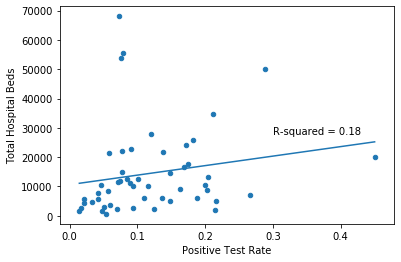

In [7]:
# Show relationship between total hospital beds and positive test rate

merged.plot.scatter(x="Positive Test Rate", y="Total Hospital Beds")
plt.plot(np.unique(merged['Positive Test Rate']), np.poly1d(np.polyfit(merged['Positive Test Rate'], merged['Total Hospital Beds'], 1))(np.unique(merged['Positive Test Rate'])))
r_squared = merged.corr().loc['Positive Test Rate', 'Total Hospital Beds']
plt.text(0.3, 28000, 'R-squared = %0.2f' % r_squared)

Text(0.32, 0.085, 'R-squared = 0.48')

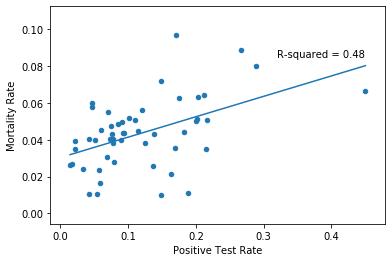

In [8]:
# Show relationship between mortality rate and positive test rate

merged.plot.scatter(x="Positive Test Rate", y="Mortality Rate")
plt.plot(np.unique(merged['Positive Test Rate']), np.poly1d(np.polyfit(merged['Positive Test Rate'], merged['Mortality Rate'], 1))(np.unique(merged['Positive Test Rate'])))
r_squared = merged.corr().loc['Positive Test Rate', 'Mortality Rate']
plt.text(0.32, 0.085, 'R-squared = %0.2f' % r_squared)

In [9]:
outcome, predictors = patsy.dmatrices("Q('Mortality Rate') ~ Q('Total Hospital Beds') + Q('Positive Test Rate')", merged)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

# note for Tesia: there is a relationship between positive test rate and mortality rate (look at coefficient and p-value, which is < 0.05)

                             OLS Regression Results                            
Dep. Variable:     Q('Mortality Rate')   R-squared:                       0.261
Model:                             OLS   Adj. R-squared:                  0.230
Method:                  Least Squares   F-statistic:                     8.482
Date:                 Fri, 05 Jun 2020   Prob (F-statistic):           0.000701
Time:                         21:37:20   Log-Likelihood:                 138.27
No. Observations:                   51   AIC:                            -270.5
Df Residuals:                       48   BIC:                            -264.7
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

# Confounding Variable (Age)

Text(0.209, 18000, 'R-squared = -0.0932')

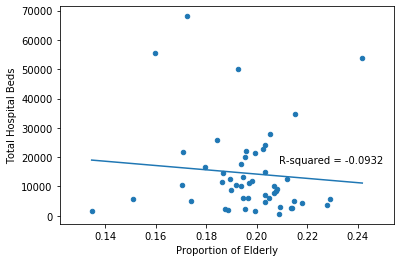

In [10]:
# Show relationship between proportion of elderly and total hospital beds

merged.plot.scatter(x="Proportion of Elderly", y="Total Hospital Beds")
plt.plot(np.unique(merged['Proportion of Elderly']), np.poly1d(np.polyfit(merged['Proportion of Elderly'], merged['Total Hospital Beds'], 1))(np.unique(merged['Proportion of Elderly'])))
r_squared = merged.corr().loc['Proportion of Elderly', 'Total Hospital Beds']
plt.text(0.209, 18000, 'R-squared = %0.4f' % r_squared)

Text(0.2, 0.075, 'R-squared = 0.0633')

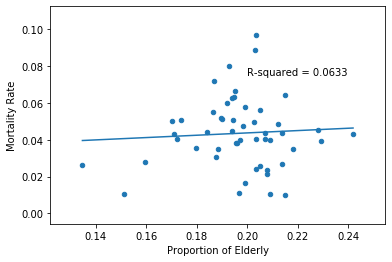

In [11]:
# Show relationship between proportion of elderly and mortality rate

merged.plot.scatter(x="Proportion of Elderly", y="Mortality Rate")
plt.plot(np.unique(merged['Proportion of Elderly']), np.poly1d(np.polyfit(merged['Proportion of Elderly'], merged['Mortality Rate'], 1))(np.unique(merged['Proportion of Elderly'])))
r_squared = merged.corr().loc['Proportion of Elderly', 'Mortality Rate']
plt.text(0.20, 0.075, 'R-squared = %0.4f' % r_squared)

In [12]:
outcome, predictors = patsy.dmatrices("Q('Mortality Rate') ~ Q('Total Hospital Beds') + Q('Proportion of Elderly')", merged)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

# note for Tesia: not confounding with the relationship between total hospital beds and mortality rate (look at coefficients, p values are also > 0.05)

                             OLS Regression Results                            
Dep. Variable:     Q('Mortality Rate')   R-squared:                       0.070
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     1.811
Date:                 Fri, 05 Jun 2020   Prob (F-statistic):              0.174
Time:                         21:37:21   Log-Likelihood:                 132.40
No. Observations:                   51   AIC:                            -258.8
Df Residuals:                       48   BIC:                            -253.0
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

# Confounding Variable (Stay at home order, issued vs not issued)

In [13]:
# convert stay_home_start_date column to a datetime object
merged['stay_home_start_date'] = pd.to_datetime(merged['stay_home_start_date'])

In [14]:
# dataframe with only states that issued a stay at home order
stay_at_home_states = merged[merged['stay_home_start_date'].notnull()]

# dataframe with only states that did not issue a stay at home order
stay_at_home_none = merged[merged['stay_home_start_date'].isnull()]

0.04634538818167668

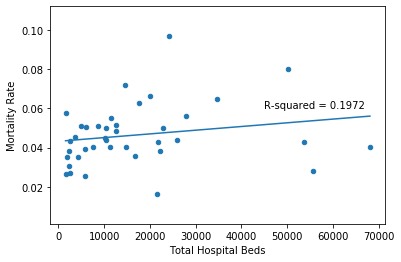

In [15]:
# relationship between total hospital beds and mortality rate for states that issued stay at home order
stay_at_home_states.plot.scatter(x="Total Hospital Beds", y="Mortality Rate")
plt.plot(np.unique(stay_at_home_states['Total Hospital Beds']), np.poly1d(np.polyfit(stay_at_home_states['Total Hospital Beds'], stay_at_home_states['Mortality Rate'], 1))(np.unique(stay_at_home_states['Total Hospital Beds'])))
r_squared = stay_at_home_states.corr().loc['Total Hospital Beds', 'Mortality Rate']
plt.text(45000, 0.06, 'R-squared = %0.4f' % r_squared)

# mean mortality rate for states with stay at home order
stay_at_home_states['Mortality Rate'].mean()

0.03424439242849842

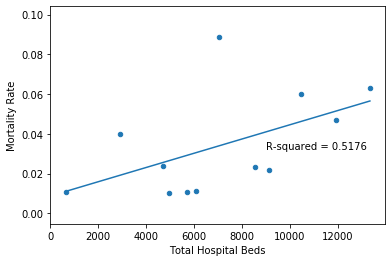

In [16]:
# relationship between total hospital beds and mortality rate for states that did not issue stay at home order
stay_at_home_none.plot.scatter(x="Total Hospital Beds", y="Mortality Rate")
plt.plot(np.unique(stay_at_home_none['Total Hospital Beds']), np.poly1d(np.polyfit(stay_at_home_none['Total Hospital Beds'], stay_at_home_none['Mortality Rate'], 1))(np.unique(stay_at_home_none['Total Hospital Beds'])))
r_squared = stay_at_home_none.corr().loc['Total Hospital Beds', 'Mortality Rate']
plt.text(9000, 0.0325, 'R-squared = %0.4f' % r_squared)

# mean mortality rate for states without stay at home order
stay_at_home_none['Mortality Rate'].mean()

# note for Tesia: although correlation is higher for states with no stay at home order, it might just be because there are more data points for the states with stay at home order (39 states vs 12 states). Can't determine whether the issue of the stay of home order played a factor in the relationship between total hospital beds and mortality rate. Also, the mean for mortality rate is lower for states that did not issue stay at home order, which is interesting

# Confounding Variable (Stay at home order, date issued for states that have one)

In [17]:
# find the number of days passed since the stay at home order (May 9 is the end date)
stay_at_home_states = stay_at_home_states.assign(
    **{'Days passed':(pd.to_datetime('05-09-20') - stay_at_home_states['stay_home_start_date']).dt.days})

Text(45, 40000, 'R-squared = 0.0420')

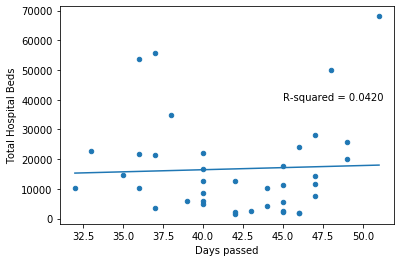

In [18]:
# Show relationship between days passed and total hospital beds

stay_at_home_states.plot.scatter(x="Days passed", y="Total Hospital Beds")
plt.plot(np.unique(stay_at_home_states['Days passed']), np.poly1d(np.polyfit(stay_at_home_states['Days passed'], stay_at_home_states['Total Hospital Beds'], 1))(np.unique(stay_at_home_states['Days passed'])))
r_squared = stay_at_home_states.corr().loc['Days passed', 'Total Hospital Beds']
plt.text(45, 40000, 'R-squared = %0.4f' % r_squared)

Text(45, 0.017, 'R-squared = 0.2996')

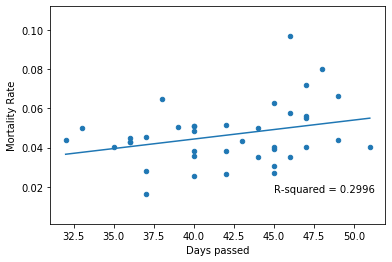

In [19]:
# Show relationship between days passed and mortality rate

stay_at_home_states.plot.scatter(x="Days passed", y="Mortality Rate")
plt.plot(np.unique(stay_at_home_states['Days passed']), np.poly1d(np.polyfit(stay_at_home_states['Days passed'], stay_at_home_states['Mortality Rate'], 1))(np.unique(stay_at_home_states['Days passed'])))
r_squared = stay_at_home_states.corr().loc['Days passed', 'Mortality Rate']
plt.text(45, 0.017, 'R-squared = %0.4f' % r_squared)

In [20]:
outcome, predictors = patsy.dmatrices("Q('Mortality Rate') ~ Q('Total Hospital Beds') + Q('Days passed')", stay_at_home_states)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

# note for Tesia: not confounding with the relationship between total hospital beds and mortality rate (look at coefficients, and p-values > 0.05)

                             OLS Regression Results                            
Dep. Variable:     Q('Mortality Rate')   R-squared:                       0.124
Model:                             OLS   Adj. R-squared:                  0.075
Method:                  Least Squares   F-statistic:                     2.545
Date:                 Fri, 05 Jun 2020   Prob (F-statistic):             0.0925
Time:                         21:37:22   Log-Likelihood:                 110.08
No. Observations:                   39   AIC:                            -214.2
Df Residuals:                       36   BIC:                            -209.2
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

# Number of Hospital Beds vs Mortality Rate

Text(40000, 0.09, 'R-squared = 0.2502')

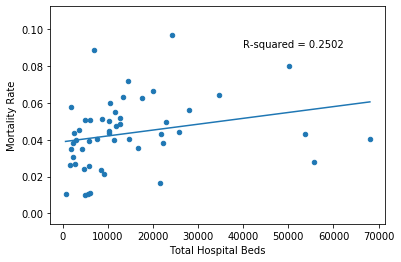

In [27]:
# Show relationship between Hospital Beds and Mortality Rate

merged.plot.scatter(x="Total Hospital Beds", y="Mortality Rate")
plt.plot(np.unique(merged['Total Hospital Beds']), np.poly1d(np.polyfit(merged['Total Hospital Beds'], merged['Mortality Rate'], 1))(np.unique(merged['Total Hospital Beds'])))
r_squared = merged.corr().loc['Total Hospital Beds', 'Mortality Rate']
plt.text(40000, 0.09, 'R-squared = %0.4f' % r_squared)

# Population Density vs Mortality Rate

Text(0.2, 0.075, 'R-squared = 0.0716')

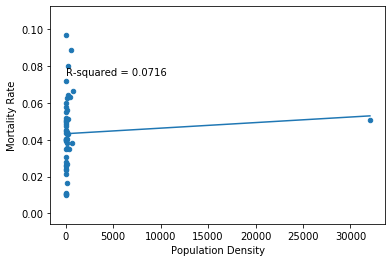

In [33]:
# Show relationship between proportion of elderly and mortality rate

merged.plot.scatter(x="Population Density", y="Mortality Rate")
plt.plot(np.unique(merged['Population Density']), np.poly1d(np.polyfit(merged['Population Density'], merged['Mortality Rate'], 1))(np.unique(merged['Population Density'])))
r_squared = merged.corr().loc['Population Density', 'Mortality Rate']
plt.text(0.20, 0.075, 'R-squared = %0.4f' % r_squared)